# Classification EDA: Airbnb Superhost Prediction
- **Dataset**: Singapore Airbnb Listings (4 timepoints combined)
- **Target**: host_is_superhost (Binary)

In [123]:
# Imports
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats

In [96]:
# Constants
FIGURES_DIRECTORY = Path("../../figures/classification")
RAW_DATA_DIRECTORY = Path("../../data/raw/")
DATA_FILE_NAMES = ["airbnb_timepoint" + f"{i}.csv" for i in range(1, 5)]

## Overview

In [97]:
# Load Data
dfs = [pl.read_csv(RAW_DATA_DIRECTORY / file_name) for file_name in DATA_FILE_NAMES]

# Check Columns
set1, set2, set3, set4 = map(set, [df.columns for df in dfs])

print("\033[1mCommon Columns:\033[0m")
for col in set1 & set2 & set3 & set4:
    print(f"• {col}")

print("\n\033[1mUnique Columns:\033[0m")
for col in (set1 | set2 | set3 | set4) - (set1 & set2 & set3 & set4):
    print(f"• {col}")

print(f"\n\033[1mTotal Columns:\033[0m {len(set1 | set2 | set3 | set4)}")

Common Columns:
• host_thumbnail_url
• host_location
• minimum_maximum_nights
• host_total_listings_count
• beds
• bedrooms
• neighbourhood_cleansed
• latitude
• longitude
• review_scores_checkin
• host_acceptance_rate
• host_has_profile_pic
• neighborhood_overview
• host_listings_count
• calculated_host_listings_count_private_rooms
• availability_30
• name
• host_id
• host_since
• calendar_updated
• neighbourhood_group_cleansed
• calendar_last_scraped
• review_scores_accuracy
• review_scores_cleanliness
• host_is_superhost
• availability_90
• review_scores_communication
• calculated_host_listings_count
• price
• first_review
• maximum_minimum_nights
• bathrooms
• property_type
• reviews_per_month
• description
• source
• availability_365
• last_review
• id
• review_scores_value
• host_response_time
• review_scores_rating
• host_neighbourhood
• has_availability
• bathrooms_text
• scrape_id
• number_of_reviews_l30d
• license
• minimum_nights
• host_identity_verified
• calculated_host_li

As seen above, most of the columns are shared between the 4 timepoints, with only 4 columns not shared between all timepoints.

Let's just drop these columns since they only make up 4 of the 79 columns.

In [98]:
df = pl.concat(dfs, how="diagonal_relaxed", rechunk=True).drop(
    list((set1 | set2 | set3 | set4) - (set1 & set2 & set3 & set4))
)

print("\033[1mCombined Dataset Details:\033")
print(f"\033[1mTotal Rows:\033[0m {df.n_unique()}")
print(f"\033[1mUnique Host IDs:\033[0m {df['id'].n_unique()}")
print(f"\033[1mColumns:\033[0m {df.shape[1]}")
df.head(10)

Combined Dataset Details:
Total Rows: 14027
Unique Host IDs: 4484
Columns: 75


id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
i64,str,i64,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,f64,f64,str,str,i64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,i64,f64,f64,str,str,i64,i64,i64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,i64,i64,i64,i64,f64
275343,"""https://www.airbnb.com/rooms/2…",20240926145704,"""2024-09-26""","""city scrape""","""10min walk to MRT & a Cozy Roo…","""**IMPORTANT NOTES: READ BEFOR…",null,"""https://a0.muscache.com/pictur…",1439258,"""https://www.airbnb.com/users/s…","""Kay""","""2011-11-24""","""Singapore""","""K2 Guesthouse is designed for …","""within an hour""","""100%""","""99%""","""f""","""https://a0.muscache.com/im/pic…","""https://a0.muscache.com/im/pic…","""Bukit Merah""",51,77,"""['email', 'phone']""","""t""","""t""",null,"""Bukit Merah""","""Central Region""",1.28986,103.80948,"""Private room in rental unit""","""Private room""",1,2.0,"""2 shared baths""",1,1,"""[""Bed linens"", ""TV"", ""Dedicate…","""$50.00""",180,999,180,180,1125,1125,180.0,1125.0,null,"""t""",0,0,0,56,"""2024-09-26""",20,0,0,"""2013-04-20""","""2022-08-13""",4.4,4.16,4.26,4.47,4.42,4.53,4.63,"""S0399""","""t""",51,0,51,0,0.14
275344,"""https://www.airbnb.com/rooms/2…",20240926145704,"""2024-09-26""","""city scrape""","""15 mins to Outram MRT Single R…","""Lovely home for the special gu…","""Bus stop <br />Food center <br…","""https://a0.muscache.com/pictur…",1439258,"""https://www.airbnb.com/users/s…","""Kay""","""2011-11-24""","""Singapore""","""K2 Guesthouse is designed for …","""within an hour""","""100%""","""99%""","""f""","""https://a0.muscache.com/im/pic…","""https://a0.muscache.com/im/pic…","""Bukit Merah""",51,77,"""['email', 'phone']""","""t""","""t""","""Singapore, Singapore""","""Bukit Merah""","""Central Region""",1.28883,103.81113,"""Private room in rental unit""","""Private room""",1,2.5,"""2.5 shared baths""",1,1,"""[""Bed linens"", ""TV"", ""Dedicate…","""$50.00""",180,999,180,180,1125,1125,180.0,1125.0,null,"""t""",0,0,0,56,"""2024-09-26""",16,0,0,"""2012-04-26""","""2023-08-16""",4.27,4.44,4.06,4.5,4.5,4.63,4.13,"""S0399""","""t""",51,0,51,0,0.11
294281,"""https://www.airbnb.com/rooms/2…",20240926145704,"""2024-09-26""","""city scrape""","""5 mins walk from Newton subway""","""I have 3 bedrooms in a charmi…",null,"""https://a0.muscache.com/pictur…",1521514,"""https://www.airbnb.com/users/s…","""Elizabeth""","""2011-12-20""","""Singapore""","""Hello ! I am Elizabeth from S…","""N/A""","""N/A""","""N/A""","""f""","""https://a0.muscache.com/im/use…","""https://a0.muscache.com/im/use…","""Central Area""",7,8,"""['email', 'phone']""","""t""","""t""",null,""

## Target Variable

In [99]:
target_col = "host_is_superhost"

# Check for null values in target
null_count = df[target_col].null_count()
print(f"\033[1mNull values in target:\033[0m {null_count}")

Null values in target: 146


Since there's only 146 rows with null target among 14027 rows in total, let's just drop these rows.

In [100]:
df = df.drop_nulls(["host_is_superhost"])
df.shape

(13881, 75)

In [101]:
# Class distribution
class_dist = (
    df[target_col]
    .value_counts()
    .sort("count")
    .with_columns(
        (
            pl.col("count")
            .truediv(df.shape[0])
            .mul(100)
            .round(decimals=2)
            .cast(pl.String)
            + "%"
        ).alias("percentage")
    )
)
print("\033[1mClass Distribution (Raw Counts):\033[0m")
display(class_dist)

# Imbalance ratio
superhost_count = len(df.filter(pl.col(target_col) == "t"))
not_superhost_count = len(df.filter(pl.col(target_col) == "f"))

imbalance_ratio = not_superhost_count / superhost_count
print(
    f"\n\033[1mImbalance Ratio:\033[0m {imbalance_ratio:.2f}:1 (Not-Superhost : Superhost)"
)

Class Distribution (Raw Counts):


host_is_superhost,count,percentage
str,u32,str
"""t""",1844,"""13.28%"""
"""f""",12037,"""86.72%"""



Imbalance Ratio: 6.53:1 (Not-Superhost : Superhost)


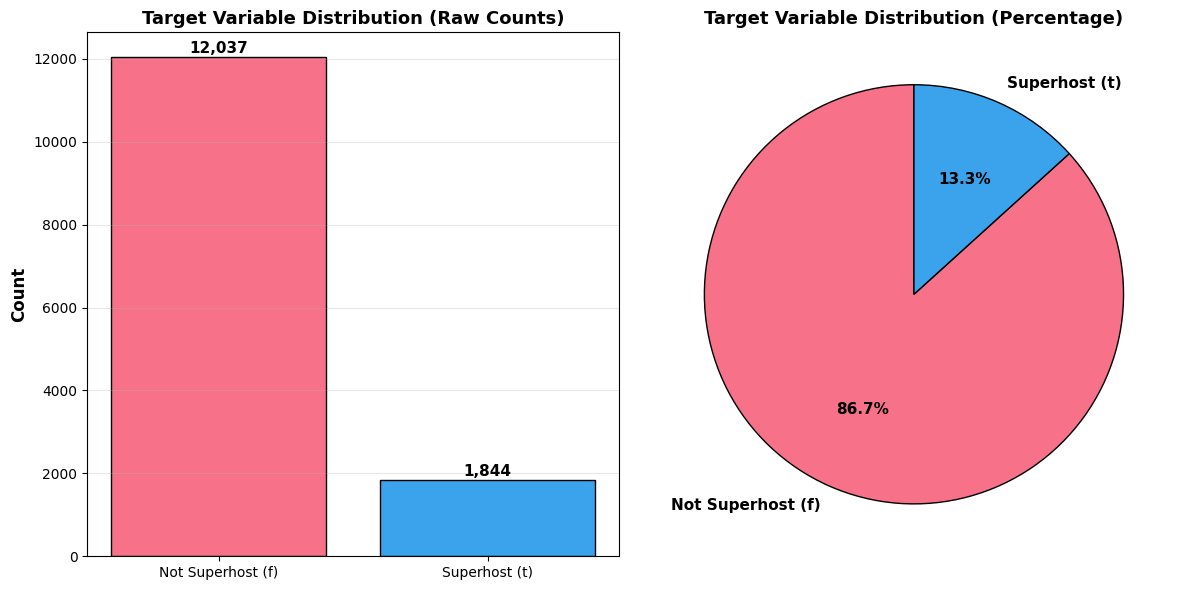

In [102]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot (counts)
class_counts = [not_superhost_count, superhost_count]
class_labels = ["Not Superhost (f)", "Superhost (t)"]
colors = [sns.color_palette("husl")[0], sns.color_palette("husl")[4]]

axes[0].bar(class_labels, class_counts, color=colors, edgecolor="black", linewidth=1)
axes[0].set_ylabel("Count", fontsize=12, fontweight="bold")
axes[0].set_title(
    "Target Variable Distribution (Raw Counts)", fontsize=13, fontweight="bold"
)
axes[0].grid(axis="y", alpha=0.3)

# Add count labels on bars
for i, count in enumerate(class_counts):
    axes[0].text(
        i, count + 100, f"{count:,}", ha="center", fontweight="bold", fontsize=11
    )

# Pie chart (percentages)
total_rows = df.shape[0]
percentages = [
    (not_superhost_count / total_rows) * 100,
    (superhost_count / total_rows) * 100,
]
axes[1].pie(
    percentages,
    labels=class_labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    textprops={"fontsize": 11, "fontweight": "bold"},
    wedgeprops={"edgecolor": "black", "linewidth": 1},
)
axes[1].set_title(
    "Target Variable Distribution (Percentage)", fontsize=13, fontweight="bold"
)

plt.tight_layout()
plt.savefig(
    FIGURES_DIRECTORY / "01_target_distribution.png", dpi=300, bbox_inches="tight"
)
plt.show()

The consolidated dataset has a severe class imbalance (6.53).

## Missing Values

In [103]:
null_values = (
    df.null_count()
    .transpose(include_header=True, column_names=["null_count"])
    .with_columns(
        (
            (pl.col("null_count") / df.shape[0] * 100).round(decimals=2).cast(pl.String)
            + "%"
        ).alias("null_percentage")
    )
    .filter(pl.col("null_count") > 0)
    .sort("null_count", descending=True)
)
display(null_values)

column,null_count,null_percentage
str,u32,str
"""calendar_updated""",13881,"""100.0%"""
"""license""",7357,"""53.0%"""
"""review_scores_location""",6941,"""50.0%"""
"""review_scores_value""",6941,"""50.0%"""
"""review_scores_accuracy""",6940,"""50.0%"""
"""review_scores_cleanliness""",6940,"""50.0%"""
"""review_scores_checkin""",6940,"""50.0%"""
"""review_scores_communication""",6940,"""50.0%"""
"""first_review""",6939,"""49.99%"""


There are a total of 41 columns with null values... this might be a problem.

Let's first visualise the top 10 columns with the most null counts.

<Figure size 1200x600 with 0 Axes>

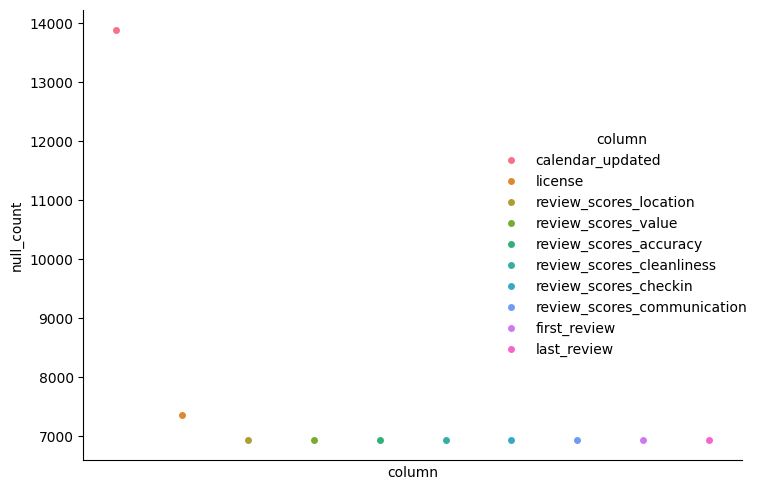

In [104]:
# Visualization
plt.figure(figsize=(12, 6))
sns.catplot(
    null_values.head(10),
    x="column",
    y="null_count",
    hue="column",
    palette="husl",
    legend=True,
    kind="swarm",
)

plt.xticks([])
plt.tight_layout()
plt.savefig(FIGURES_DIRECTORY / "02_missing_values.png", dpi=300, bbox_inches="tight")
plt.show()

### Data-Cleaning Strategy

Let's figure out:
- Which columns can we drop? (no real information)
- Which columns are feasible to just drop null rows? (very few null values)
- Which columns can we impute? (reasonable to alter)

In [105]:
# Convert Null Percentages back to Floats
null_values = null_values.with_columns(
    pl.col("null_percentage")
    .str.replace(r"%", "")
    .cast(pl.Float64)
    .alias("null_percentage")
)

In [106]:
# Check all columns for droppable columns
print(f"\033[1mAll Columns with Null Values:\033[0m")
for col in null_values["column"].to_list():
    print(f"• {col}")

All Columns with Null Values:
• calendar_updated
• license
• review_scores_location
• review_scores_value
• review_scores_accuracy
• review_scores_cleanliness
• review_scores_checkin
• review_scores_communication
• first_review
• last_review
• review_scores_rating
• reviews_per_month
• neighborhood_overview
• neighbourhood
• host_location
• beds
• price
• bathrooms
• bedrooms
• has_availability
• host_neighbourhood
• description
• host_name
• host_since
• host_about
• host_response_time
• host_response_rate
• host_acceptance_rate
• host_thumbnail_url
• host_picture_url
• host_listings_count
• host_total_listings_count
• host_has_profile_pic
• host_identity_verified
• bathrooms_text
• minimum_minimum_nights
• maximum_minimum_nights
• minimum_maximum_nights
• maximum_maximum_nights
• minimum_nights_avg_ntm
• maximum_nights_avg_ntm


In [107]:
droppable_columns = [
    "calendar_updated",  # 100% Null
    "license",  # Hard to Interpret
    "host_thumbnail_url",  # Hard to Process
    "host_picture_url",  # Hard to Process
]

null_values = null_values.remove(pl.col("column").str.contains_any(droppable_columns))

In [108]:
# Columns feasible to drop null rows
row_droppable_columns = null_values.filter(pl.col("null_percentage") < 2.5)[
    "column"
].to_list()
null_values = null_values.remove(
    pl.col("column").str.contains_any(row_droppable_columns)
)
row_droppable_columns

['description',
 'host_name',
 'host_since',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'bathrooms_text',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm']

In [109]:
# How many columns are left?
pl.Config.set_tbl_rows(20)
null_values

column,null_count,null_percentage
str,u32,f64
"""review_scores_location""",6941,50.0
"""review_scores_value""",6941,50.0
"""review_scores_accuracy""",6940,50.0
"""review_scores_cleanliness""",6940,50.0
"""review_scores_checkin""",6940,50.0
"""review_scores_communication""",6940,50.0
"""first_review""",6939,49.99
"""last_review""",6939,49.99
"""review_scores_rating""",6939,49.99


Imputable Columns:
- `Review` Columns all have ~50% null rows -> create has_reviews flag
- `host_location`, `beds`, `bathrooms`, `bedrooms` -> "Unknown" for null values

Remainder Columns:
- `price` should be processed to numerical, but has 24.86% null values... maybe bite the bullet and remove these rows?
- `has_availability` only has 8.03% null values, maybe drop these rows if total rows remaining is sufficient.
- Remainding columns should likely be dropped, since they comprise a lot of null values but don't bring mu real information.

## Feature Inputs

In [110]:
# Schema
schema = df.schema
numerical_features = []
categorical_features = []
text_features = []

# Categorize
for col_name, data_type in schema.items():
    if col_name == target_col:
        continue

    data_type_str = str(data_type)

    if "Int" in data_type_str or "Float" in data_type_str:
        numerical_features.append(col_name)
    elif "String" in data_type_str:
        # Determine if it's truly categorical or text
        unique_count = df[col_name].n_unique()
        total_count = len(df)

        if unique_count < 100 or unique_count / total_count < 0.1:
            categorical_features.append((col_name, unique_count))
        else:
            text_features.append((col_name, unique_count))
    else:
        categorical_features.append((col_name, "Other"))

# Print
print(f"\033[1mNumerical Features ({len(numerical_features)})\033[0m")
for feat in numerical_features:
    print(f"  • {feat}")

print(f"\n\033[1mCategorical Features ({len(categorical_features)})\033[0m")
for feat, unique_count in categorical_features:
    print(f"  - {feat:30}" + f"({unique_count} unique values)")

print(f"\n\033[1mText/High-Cardinality Features ({len(text_features)})\033[0m")
for feat, unique_count in text_features:
    print(f"  - {feat:30}({unique_count:,} unique values)")

Numerical Features (38)
  • id
  • scrape_id
  • host_id
  • host_listings_count
  • host_total_listings_count
  • latitude
  • longitude
  • accommodates
  • bathrooms
  • bedrooms
  • beds
  • minimum_nights
  • maximum_nights
  • minimum_minimum_nights
  • maximum_minimum_nights
  • minimum_maximum_nights
  • maximum_maximum_nights
  • minimum_nights_avg_ntm
  • maximum_nights_avg_ntm
  • availability_30
  • availability_60
  • availability_90
  • availability_365
  • number_of_reviews
  • number_of_reviews_ltm
  • number_of_reviews_l30d
  • review_scores_rating
  • review_scores_accuracy
  • review_scores_cleanliness
  • review_scores_checkin
  • review_scores_communication
  • review_scores_location
  • review_scores_value
  • calculated_host_listings_count
  • calculated_host_listings_count_entire_homes
  • calculated_host_listings_count_private_rooms
  • calculated_host_listings_count_shared_rooms
  • reviews_per_month

Categorical Features (30)
  - last_scraped                 

### Numerical Features

In [111]:
# Summary statistics
numerical_stats = df.select(numerical_features).describe()
print("\033[1mSummary Statistics:\033[0m")
display(numerical_stats)

Summary Statistics:


statistic,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",13881.0,13881.0,13881.0,13749.0,13749.0,13881.0,13881.0,13881.0,10547.0,12713.0,10404.0,13881.0,13881.0,13877.0,13877.0,13877.0,13877.0,13877.0,13877.0,13881.0,13881.0,13881.0,13881.0,13881.0,13881.0,13881.0,6942.0,6941.0,6941.0,6941.0,6941.0,6940.0,6940.0,13881.0,13881.0,13881.0,13881.0,6942.0
"""null_count""",0.0,0.0,0.0,132.0,132.0,0.0,0.0,0.0,3334.0,1168.0,3477.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6939.0,6940.0,6940.0,6940.0,6940.0,6941.0,6941.0,0.0,0.0,0.0,0.0,6939.0
"""mean""",4.8743e17,2.0246e13,1.7721e8,73.856717,123.00691,1.310333,103.843559,2.709747,1.436143,1.257217,1.615917,64.061091,695.655428,62.715717,63.433307,766.522303,801.085177,63.121763,784.819759,19.034868,41.418918,65.0134,250.617319,10.702975,2.083135,0.15107,4.554503,4.59438,4.527417,4.745627,4.724302,4.706687,4.450112,43.569123,31.224263,11.956631,0.168864,0.559101
"""std""",5.4400e17,4.6999e9,1.8497e8,137.928882,236.642017,0.03085,0.043209,1.894318,0.917606,0.777926,1.371046,56.358413,1736.418701,56.689879,56.571382,1825.154029,1818.843696,56.499843,1820.762373,12.415644,23.462339,34.11956,132.898845,41.170145,12.034173,1.070101,0.598529,0.589271,0.618921,0.46353,0.521231,0.438388,0.622405,61.633114,62.360327,22.557355,1.249386,1.419043
"""min""",71609.0,2.0241e13,23666.0,1.0,1.0,1.22169,103.63457,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.01
"""25%""",3.0385269e7,2.0241e13,2.8809566e7,3.0,5.0,1.29267,103.83375,1.0,1.0,1.0,1.0,6.0,365.0,6.0,6.0,365.0,365.0,6.0,365.0,1.0,24.0,52.0,148.0,0.0,0.0,0.0,4.36,4.48,4.33,4.67,4.67,4.6,4.21,3.0,0.0,1.0,0.0,0.04
"""50%""",5.2525344e7,2.0250e13,1.22468322e8,12.0,19.0,1.30449,103.84445,2.0,1.0,1.0,1.0,92.0,365.0,92.0,92.0,730.0,731.0,92.0,730.0,26.0,56.0,86.0,325.0,1.0,0.0,0.0,4.75,4.8,4.73,4.92,4.92,4.86,4.6,12.0,1.0,2.0,0.0,0.16
"""75%""",1.0571e18,2.0251e13,2.38891646e8,69.0,101.0,1.31729,103.85998,4.0,2.0,1.0,2.0,92.0,1125.0,92.0,92.0,1125.0,1125.0,92.0,1125.0,29.0,59.0,89.0,364.0,4.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,4.93,65.0,25.0,9.0,0.0,0.55
"""max""",1.4505e18,2.0251e13,7.02361576e8,533.0,886.0,1.457802,103.98957,16.0,21.0,11.0,46.0,730.0,100000.0,730.0,730.0,100000.0,100000.0,730.0,100000.0,30.0,60.0,90.0,365.0,1243.0,340.0,34.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,232.0,232.0,100.0,18.0,27.11


In [112]:
# Let's also check a few of the more interesting features
features = {
    "review_scores_cleanliness": "Higher = Better",
    "review_scores_rating": "Higher = Better",
    "minimum_nights": "Lower = More Flexible",
    "number_of_reviews": "Higher = More Active",
    "accommodates": "Higher = Larger Space",
}

for feat, interpretation in features.items():
    sh = df.filter(pl.col(target_col) == "t")[feat].drop_nulls().to_numpy()
    nsh = df.filter(pl.col(target_col) == "f")[feat].drop_nulls().to_numpy()

    sh_mean = np.mean(sh)
    nsh_mean = np.mean(nsh)
    diff = sh_mean - nsh_mean

    print(f"\n\033[1m{feat}: ({interpretation})\033[0m")
    print(f"  Superhosts:     {sh_mean:.2f}")
    print(f"  Non-superhosts: {nsh_mean:.2f}")
    print(f"  Difference:     {diff:+.2f} ({diff / nsh_mean * 100:+.1f}%)")


review_scores_cleanliness: (Higher = Better)
  Superhosts:     4.81
  Non-superhosts: 4.46
  Difference:     +0.35 (+7.9%)

review_scores_rating: (Higher = Better)
  Superhosts:     4.78
  Non-superhosts: 4.50
  Difference:     +0.28 (+6.3%)

minimum_nights: (Lower = More Flexible)
  Superhosts:     40.99
  Non-superhosts: 67.60
  Difference:     -26.60 (-39.4%)

number_of_reviews: (Higher = More Active)
  Superhosts:     19.76
  Non-superhosts: 9.32
  Difference:     +10.45 (+112.2%)

accommodates: (Higher = Larger Space)
  Superhosts:     2.62
  Non-superhosts: 2.72
  Difference:     -0.10 (-3.7%)


### Categorical Features

In [113]:
# Let's check some interesting ones instead of all of them
for feat in [
    "host_response_time",
    "host_response_rate",
    "host_acceptance_rate",
    "host_identity_verified",
    "property_type",
    "room_type",
    "has_availability",
    "instant_bookable",
]:
    try:
        result = (
            df.group_by(feat)
            .agg(
                (pl.col(target_col) == "t").sum().alias("superhosts"),
                pl.col(target_col).len().alias("total"),
            )
            .with_columns(
                (pl.col("superhosts") / pl.col("total") * 100).alias("superhost_rate_%")
            )
            .sort("superhost_rate_%", descending=True)
        )

        print(f"\n\033[1m{feat}:\033[0m")
        for row in result.head(5).to_dicts():
            cat = row[feat]
            rate = row["superhost_rate_%"]
            count = row["total"]
            if count > 1:
                print(f"  {cat}: {rate:.1f}% superhost ({count} listings)")

    except Exception as e:
        print(e)


host_response_time:
  within an hour: 28.2% superhost (5247 listings)
  within a few hours: 19.2% superhost (1401 listings)
  within a day: 2.5% superhost (2594 listings)
  N/A: 0.8% superhost (3510 listings)
  a few days or more: 0.3% superhost (997 listings)

host_response_rate:
  94%: 75.4% superhost (57 listings)
  53%: 60.0% superhost (20 listings)
  96%: 37.5% superhost (48 listings)
  99%: 29.5% superhost (579 listings)

host_acceptance_rate:
  28%: 100.0% superhost (13 listings)
  84%: 98.1% superhost (106 listings)
  85%: 94.9% superhost (78 listings)
  36%: 92.9% superhost (14 listings)

host_identity_verified:
  f: 13.6% superhost (1362 listings)
  t: 13.4% superhost (12387 listings)
  None: 0.0% superhost (132 listings)

property_type:
  Room in aparthotel: 85.7% superhost (210 listings)
  Private room in resort: 75.0% superhost (4 listings)
  Private room in villa: 73.6% superhost (53 listings)
  Shared room in boutique hotel: 63.0% superhost (27 listings)
  Private room 

## Correlation Analysis

In [114]:
# For expedition, dropping all rows with nulls
# This removes over half of all rows so results should be interpreted with caution
corr_df = (
    df.with_columns(
        pl.when(pl.col("host_is_superhost") == "t")
        .then(1)
        .otherwise(0)
        .cast(pl.Int8)
        .alias("superhost")
    )
    .select(numerical_features + ["superhost"])
    .drop_nulls()
    .corr()
)

corr = pl.DataFrame(
    {"feature": corr_df.columns, "correlation": corr_df["superhost"]}
).sort(pl.col("correlation").abs(), descending=True)

print("\033[1mTop 15 Correlations:\033[0m")
pl.Config.set_tbl_rows(15)
corr.head(15)

Top 15 Correlations:


feature,correlation
str,f64
"""superhost""",1.0
"""review_scores_cleanliness""",0.240774
"""review_scores_rating""",0.18952
"""review_scores_accuracy""",0.189062
"""minimum_minimum_nights""",-0.185506
"""minimum_nights_avg_ntm""",-0.180069
"""minimum_nights""",-0.179902
"""maximum_minimum_nights""",-0.177624
"""calculated_host_listings_count…",-0.173181


## Bivariate Analysis
### Numerical Features

/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_44314/411708110.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([non_superhosts, superhosts], labels=["Not", "Super"])
/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_44314/411708110.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([non_superhosts, superhosts], labels=["Not", "Super"])
/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_44314/411708110.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([non_superhosts, superhosts], labels=["Not", "Super"])
/var/folders/9x/42ryqw3d4t70f298p11c89gh000

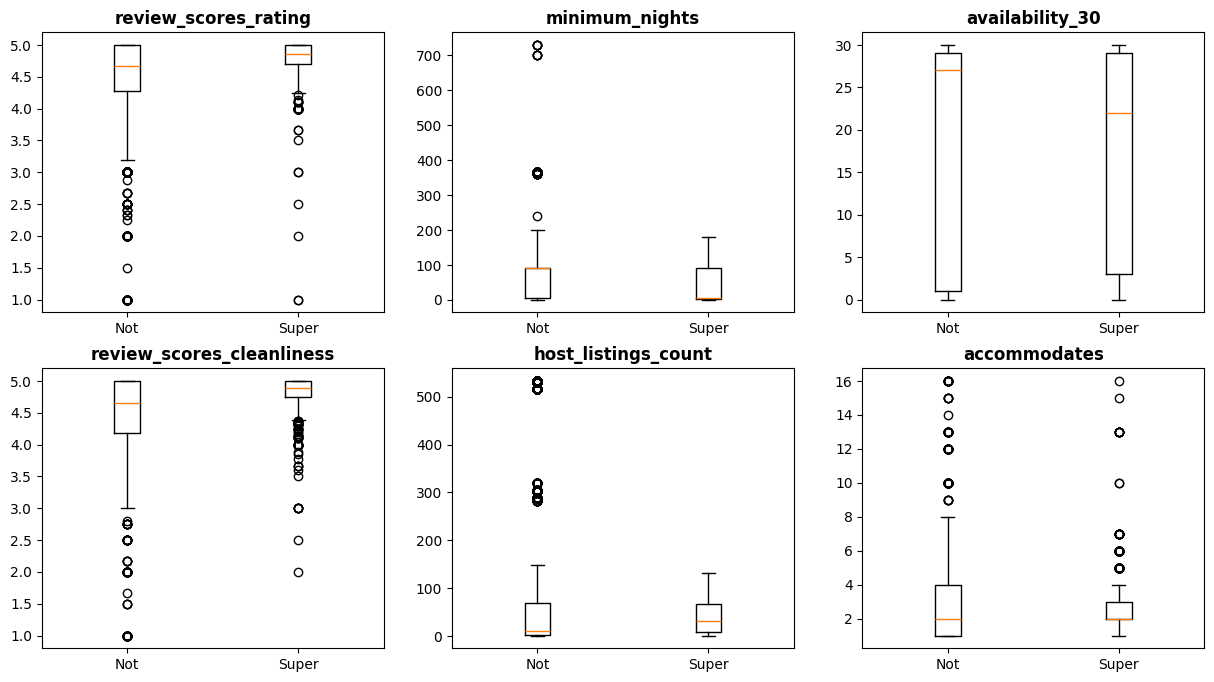

In [115]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Let's just pick a few interesting features to look at
for idx, feat in enumerate(
    [
        "review_scores_rating",
        "minimum_nights",
        "availability_30",
        "review_scores_cleanliness",
        "host_listings_count",
        "accommodates",
    ]
):
    ax = axes[idx // 3, idx % 3]
    superhosts = df.filter(pl.col(target_col) == "t")[feat].drop_nulls()
    non_superhosts = df.filter(pl.col(target_col) == "f")[feat].drop_nulls()
    ax.boxplot([non_superhosts, superhosts], labels=["Not", "Super"])
    ax.set_title(feat, fontweight="bold")

### Text Features

In [116]:
df = df.with_columns(
    [
        pl.col("amenities").str.len_chars().alias("amenities_length"),
        pl.col("description").str.len_chars().alias("description_length"),
    ]
)

# Compare by superhost status
display(
    df.group_by(target_col).agg(
        [
            pl.col("amenities_length").mean(),
            pl.col("description_length").mean(),
        ]
    )
)

host_is_superhost,amenities_length,description_length
str,f64,f64
"""t""",465.668655,406.170931
"""f""",365.773698,337.155365


### Insights

#### Positive Predictors for Superhosts

1. **Review Quality**
   - Superhosts: 4.81/5.0 cleanliness vs Non: 4.46/5.0 (+7.9%)
   - Leakage: Review scores are explicit Airbnb superhost criteria
   - 50% data lacks reviews (new listings) → sample bias

2. **Response Speed**
   - Within hour: 28.2% superhost | Within day: 2.5% superhost | N/A: 0.8%
   - Causal: Fast response → Better guest experience → Better reviews → Superhost
   - Action: Encode as ordinal (1=n/a, 2=day, 3=hours, 4=within_hour)

3. **Minimum Nights Flexibility**
   - Superhosts: 40.99 min nights | Non-superhosts: 67.60 min nights (-39.4%)
   - Causal: Lower minimums → More bookings → More reviews → Superhost status
   - Superhosts have 112% more reviews (19.76 vs 9.32)

4. **Text Effort**
   - Superhosts: 465.7 char amenities, 406.2 char description
   - Non-superhosts: 365.8 char, 337.2 char (+27% amenities, +20% description)
   - No leakage. Indicates effort invested in marketing

#### Negative Predictors for Superhosts

1. **High Availability**
   - Higher availability paradoxically predicts non-superhost
   - Hypothesis: Superhosts are BOOKED more (low availability due to demand)

2. **Guest Vetting Behavior (Instant Bookable)**
   - Superhosts vs Non-Superhosts: 15.4% have instant_bookable=false, 10.2% have instant_bookable=true
   - Causal: Superhosts vet guests (disable instant booking) → Better experience

#### Data Quality Issues

**Issue 1: Class Imbalance (6.53:1)**
- Superhost: 1,844 (13.28%) | Non-superhost: 12,037 (86.72%)
- Impact: Accuracy metric useless (always predict "not superhost" = 86.7%)
- Solution: Apply data balancing techniques in data preprocessing notebook to address class imbalance.

**Issue 2: Missing Review Data (50% Missing)**
- Review scores: 50% null (new listings without guests)
- Solution: Create binary flag `has_reviews`. Impute nulls with median.

**Issue 3: High-Cardinality Categoricals**
- property_type: 55 unique values → Target encode to top 10 + "Other"
- neighbourhood: 45 unique values → Group low-frequency areas
- host_response_rate: 51 unique values → Bin into quartiles

## Summary

In [121]:
findings = f"""
\033[1mDATASET OVERVIEW:\033[0m
  - Total Records: {len(df):,}
  - Total Features: {df.width}
  - Numerical Features: {len(numerical_features)}
  - Categorical Features: {len(categorical_features)}
  - Text Features: {len(text_features)}

\033[1mCLASS IMBALANCE:\033[0m
  - Superhost (Positive Class): {superhost_count:,} ({(superhost_count / total_rows) * 100:.2f}%)
  - Not Superhost (Negative Class): {not_superhost_count:,} ({(not_superhost_count / total_rows) * 100:.2f}%)
  - Imbalance Ratio: {imbalance_ratio:.2f}:1

\033[1mMISSING DATA:\033[0m
  - {len(null_values)} columns have missing values
  - Maximum missing percentage: {null_values["null_percentage"].max()}%
"""

print(findings)


DATASET OVERVIEW:
  - Total Records: 13,881
  - Total Features: 77
  - Numerical Features: 38
  - Categorical Features: 30
  - Text Features: 6

CLASS IMBALANCE:
  - Superhost (Positive Class): 1,844 (13.28%)
  - Not Superhost (Negative Class): 12,037 (86.72%)
  - Imbalance Ratio: 6.53:1

MISSING DATA:
  - 19 columns have missing values
  - Maximum missing percentage: 50.0%

